In [1]:
import os
import shutil
from collections import Counter
from timeit import default_timer as timer
%load_ext autoreload
%autoreload 2

# !pip install numpy==1.22
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# from PIL import Image
# import cv2

!pip install ipywidgets

import seaborn as sns
from matplotlib import pyplot as plt

import engine
import helper_functions

for filename in os.listdir('/kaggle/input'):
    print(filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


fungi-all


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchinfo import summary
import time

from tempfile import TemporaryDirectory

# cudnn.benchmark = True
# plt.ion() 
print(torch.__version__)

2.0.0


# Setup device agnostic code

In [3]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Merging test-train-valid directories

As we observed during data exploration the test and valid directories are not balanced although the train directory is. We decided to merge all the directories in one directory destination_dir = '/kaggle/working/all', perform cross-validation and evaluate the model using balanced accuracy.


In [4]:
# Define the directory path to check
directory_to_check = '/kaggle/input/fungi-all'

# Check if the directory exists
if not os.path.exists(directory_to_check):
    # Define the source and destination directories
    source_base_dir = '/kaggle/input/microscopic-fungi-images'
    destination_dir = '/kaggle/working/fungi-all'

    # List of subdirectories to merge
    subdirectories_to_merge = ['H1', 'H2', 'H3', 'H5', 'H6']

    # Create the destination directory if it doesn't exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Loop through each of the train, test, and val directories
    for dataset_dir in ['train', 'test', 'valid']:
        # Loop through the subdirectories to merge
        for subdirectory in subdirectories_to_merge:
            # Define the source and destination paths
            source_path = os.path.join(source_base_dir, dataset_dir, subdirectory)
            destination_path = os.path.join(destination_dir, subdirectory)

            # Create a directory for the class if it doesn't exist
            if not os.path.exists(destination_path):
                os.makedirs(destination_path)

            # Copy the files from source to destination
            for filename in os.listdir(source_path):
                source_file = os.path.join(source_path, filename)
                destination_file = os.path.join(destination_path, filename)
                shutil.copy(source_file, destination_file)

        # Define the directory path
        all_directory = '/kaggle/working/fungi-all'

    print("Files merged successfully.")
            
else:
        all_directory = '/kaggle/input/fungi-all'
        print("fungi-all exists")

            

fungi-all exists


In [5]:
# List of subdirectories to check
subdirectories_to_check = ['H1', 'H2', 'H3', 'H5', 'H6']

# Loop through the subdirectories
for subdirectory in subdirectories_to_check:
    subdirectory_path = os.path.join(all_directory, subdirectory)
    
    # Check if the directory exists
    if os.path.exists(subdirectory_path):
        # Count the number of files in the directory
        num_files = len(os.listdir(subdirectory_path))
        print(f"Number of files in '{subdirectory}': {num_files}")
    else:
        print(f"'{subdirectory}' directory does not exist in '{all_directory}'.")

Number of files in 'H1': 1874
Number of files in 'H2': 1465
Number of files in 'H3': 1163
Number of files in 'H5': 1160
Number of files in 'H6': 1139


## Load Data and Visualize them

In [6]:
DATA_DIR = all_directory

dataset = ImageFolder(DATA_DIR)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 6801
    Root location: /kaggle/input/fungi-all


In [7]:
labels = dataset.targets
dataset.class_to_idx

{'H1': 0, 'H2': 1, 'H3': 2, 'H5': 3, 'H6': 4}

### Visualize a few randomly selected images

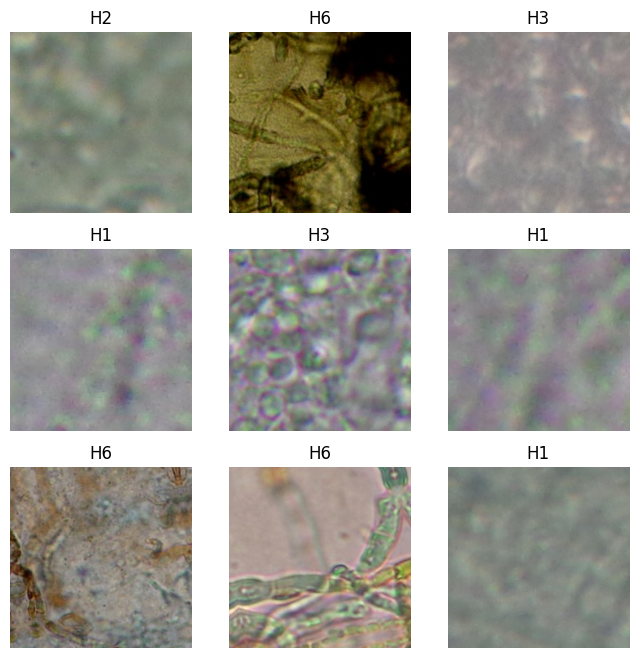

In [8]:
labels_map = {
    0: "H1",
    1: "H2",
    2: "H3",
    3: "H5",
    4: "H6",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item() # generate a random integer in the dataset range
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

### Plot the classes' distribution

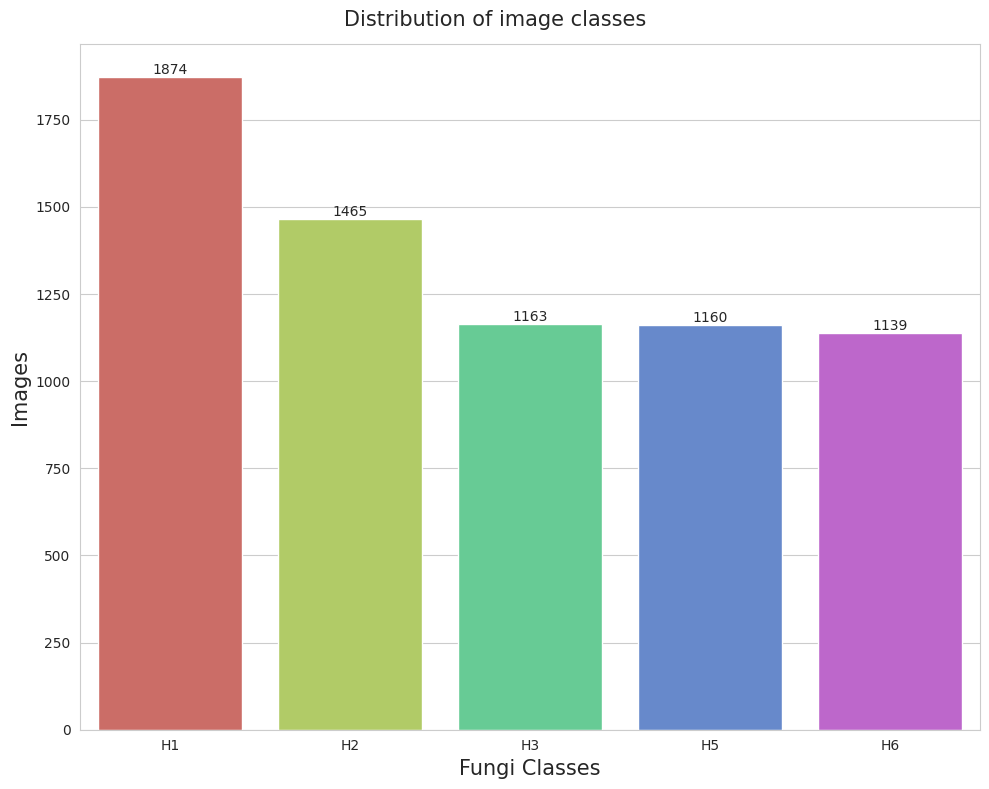

In [9]:
img_per_class = dict(Counter(dataset.targets))

plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(x=dataset.classes, y=[value for value in img_per_class.values()], color='blue', palette='hls')
ax.bar_label(ax.containers[0])

plt.xlabel('Fungi Classes', fontsize=15)
plt.ylabel(f'Images', fontsize=15)


plt.suptitle(f'Distribution of image classes', fontsize=15)
plt.savefig(f'/kaggle/working/classes_distribution.png')
plt.show()

 ## Split into stratified train,val, test subsets and store into folders (Kiriakos' function)

In [10]:
def split_dataset(dataset, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("The sum of train_ratio, val_ratio, and test_ratio should be 1.0")
        
    # initial split
    train_data, test_data, train_labels, test_labels = train_test_split(
        dataset, labels, test_size=test_ratio, random_state=random_seed, stratify=labels)
    remaining_ratio = val_ratio / (train_ratio + val_ratio)
    # rain-validation split
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size=remaining_ratio, random_state=random_seed, stratify=train_labels)
    
    return train_data, val_data, test_data

# Load pretrained ResNet50 and inspect

Load the vgg16 model available in torchvision and use the pretrained weights to do transfer learning. Reset final fully connected layer to output the classes of our dataset.

Find the transforms the model used during training.

In [11]:
weights = models.ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s] 


In [12]:
summary(resnet, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [13]:
# Find the tranforms that the prertained model used
transform=weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

## Reset the final layer according to our number of classes.

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
class_names = dataset.classes
output_shape = len(class_names)

# get the number of input features for the final layer
num_ftrs = resnet.fc.in_features

#Reset the final layer
resnet.fc = nn.Linear(num_ftrs, output_shape).to(device)
resnet = resnet.to(device)

In [15]:
summary(resnet, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
       )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 5]              --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

## Define a loss function and an optimizer

We chose to use a weighted cross entropy loss function to factor in the class imbalance. The weights we used are the percentages of images in each class.

In [16]:
total_imgs = len(dataset)
num_classes = len(dataset.classes)
weights = torch.tensor([total_imgs/(class_imgs*num_classes) for class_imgs in img_per_class.values()]).to(device)
print(weights)

# define the CrossEntropyLoss with weights
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

tensor([0.7258, 0.9285, 1.1696, 1.1726, 1.1942], device='cuda:0')


# Prepare dataset for cross validation

Load dataset with different transforms for the train and test splits. The transforms used are the ones the pretrained model weights were optimized on. Using the same transforms usually yields better performance when fine-tuning or using the model for feature extraction.

It is important to make sure that all values are scaled to the range [0..1] before we pass them to a neural network - it is the usual convention for data preparation, and all default weight initializations in neural networks are designed to work with this range. The transform.ToTensor() method does this tranformation.

It is important to note that all images should be scaled to the same size. The transform.Resize() method performs bilinear interpolation by default. Since our images are already in the size of 224x224 or smaller we decided not to first resize to 256 and then crop to 224 as the pretrained model suggests, in feat of losing information. We only resized them all to 224x224.

Normalization is done with the ImageNet means and stds.

The test set will be held out separately for testing the final model after cross validation

In [17]:
# Define different transforms for the train and test sets
train_transforms = transforms.Compose([
    # data augmentations can go here
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
train_dataset = ImageFolder(DATA_DIR, transform=train_transforms)
test_dataset = ImageFolder(DATA_DIR, transform=test_transforms)

# Create a list of indices from 0 to length of dataset
indices = list(range(len(train_dataset)))

# Retrieve the labels from the dataset
labels = [label for _, label in train_dataset]

# Perform stratified split
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.15,  # 15% test, 85% train
    stratify=labels,
    random_state=42  # To ensure reproducibility
)

# Create train, test data with Subset using the indices generated above
train_subset = Subset(train_dataset, train_idx)
train_targets=[train_dataset.targets[i] for i in train_idx]
train_targets_counts=Counter(train_targets)
print(train_targets_counts, len(train_subset))

test_subset = Subset(test_dataset, test_idx)
test_targets=[test_dataset.targets[i] for i in test_idx]
test_targets_counts=Counter(test_targets)
print(test_targets_counts, len(test_subset))

# Create Test DataLoader
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

Counter({0: 1593, 1: 1245, 2: 988, 3: 986, 4: 968}) 5780
Counter({0: 281, 1: 220, 2: 175, 3: 174, 4: 171}) 1021


## Create dataloaders for 5 stratified folds of the training subset

In [19]:
# First we will create our train and test dataloaders using StratifiedKFold from sklearn

data_loaders = []
class_counts_per_split=[]

reduced_dataset = train_subset

# Perform cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = [dataset.imgs[i] for i in train_idx]
y = [dataset.targets[i] for i in train_idx]

for i, (train_indices, val_indices) in enumerate(stratified_kfold.split(X, y)):
    # Get the class labels for the training and testing sets of this split
    train_classes = [y[idx] for idx in train_indices]
    val_classes = [y[idx] for idx in val_indices]
    
    # Count the occurrences of each class in the training and testing sets
    train_class_counts = Counter(train_classes)
    val_class_counts = Counter(val_classes)
    
    # Append the counts to the list
    class_counts_per_split.append((f"Split {i+1}", train_class_counts, val_class_counts))

    # Create subsets of the dataset for training and testing using the indices
    train_subset = Subset(reduced_dataset, train_indices)
    val_subset = Subset(reduced_dataset, val_indices)
    
    # Create data loaders for training and testing
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    data_loaders.append((train_loader, val_loader))

    # Print class counts for this split
    print(f"Split {i+1}:")
    print("Train Set Class Counts:", train_class_counts)
    print("Val Set Class Counts:", val_class_counts)
    print()
    print("Train DataLoader:", train_loader)
    print("Val DataLoader:", val_loader)
    print()

Split 1:
Train Set Class Counts: Counter({0: 1274, 1: 996, 2: 791, 3: 789, 4: 774})
Val Set Class Counts: Counter({0: 319, 1: 249, 3: 197, 2: 197, 4: 194})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f2758392440>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f27583921a0>

Split 2:
Train Set Class Counts: Counter({0: 1274, 1: 996, 2: 791, 3: 789, 4: 774})
Val Set Class Counts: Counter({0: 319, 1: 249, 3: 197, 2: 197, 4: 194})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f2758391360>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f27583910c0>

Split 3:
Train Set Class Counts: Counter({0: 1274, 1: 996, 2: 790, 3: 789, 4: 775})
Val Set Class Counts: Counter({0: 319, 1: 249, 2: 198, 3: 197, 4: 193})

Train DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f2758393790>
Val DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f27583937c0>

Split 4:
Train Set Class Cou

In [20]:
print(data_loaders)

[(<torch.utils.data.dataloader.DataLoader object at 0x7f2758392440>, <torch.utils.data.dataloader.DataLoader object at 0x7f27583921a0>), (<torch.utils.data.dataloader.DataLoader object at 0x7f2758391360>, <torch.utils.data.dataloader.DataLoader object at 0x7f27583910c0>), (<torch.utils.data.dataloader.DataLoader object at 0x7f2758393790>, <torch.utils.data.dataloader.DataLoader object at 0x7f27583937c0>), (<torch.utils.data.dataloader.DataLoader object at 0x7f27583ab910>, <torch.utils.data.dataloader.DataLoader object at 0x7f27583abc70>), (<torch.utils.data.dataloader.DataLoader object at 0x7f27583ab880>, <torch.utils.data.dataloader.DataLoader object at 0x7f27583ab850>)]


# Perform Cross Validation

We can now evaluate the model using a loop to iterate through our 5 dataloaders. We append the results in `results_all` list 

In [21]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_all=[]
# init_weights = vgg16.state_dict()

for i in range(5):
    print(f"Split:{i}")
    start_time = timer()
    
    # Load the model
    weights = models.ResNet50_Weights.DEFAULT
    resnet = models.resnet50(weights=weights).to(device)
    num_ftrs = resnet.fc.in_features

    resnet.fc = nn.Linear(num_ftrs, 5).to(device)
    
    # Set the optimizer
    optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)
    exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)
    
    print('Model was reset')
    results, _ = engine.train_with_early_stopping(model=resnet,
                                                  train_dataloader=data_loaders[i][0],
                                                  valid_dataloader=data_loaders[i][1],
                                                  optimizer=optimizer,
                                                  loss_fn=loss_fn,
                                                  epochs=20,
                                                  device=device)

    results_all.append(results)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time of split {i}: {end_time-start_time:.3f} seconds")

Split:0
Model was reset


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9329 | train_bal_acc: 0.6618 | train_mcc: 0.5505 | valid_loss: 0.5527 | valid_bal_acc: 0.7840 | valid_mcc: 0.7058
Epoch: 2 | train_loss: 0.4558 | train_bal_acc: 0.8380 | train_mcc: 0.7711 | valid_loss: 0.4410 | valid_bal_acc: 0.8353 | valid_mcc: 0.7669
Epoch: 3 | train_loss: 0.2425 | train_bal_acc: 0.9237 | train_mcc: 0.8843 | valid_loss: 0.4297 | valid_bal_acc: 0.8460 | valid_mcc: 0.7999
Epoch: 4 | train_loss: 0.1430 | train_bal_acc: 0.9587 | train_mcc: 0.9366 | valid_loss: 0.3902 | valid_bal_acc: 0.8664 | valid_mcc: 0.8178
Epoch: 5 | train_loss: 0.0900 | train_bal_acc: 0.9765 | train_mcc: 0.9593 | valid_loss: 0.4776 | valid_bal_acc: 0.8539 | valid_mcc: 0.7921
Epoch: 6 | train_loss: 0.0738 | train_bal_acc: 0.9825 | train_mcc: 0.9701 | valid_loss: 0.5009 | valid_bal_acc: 0.8507 | valid_mcc: 0.7957
Epoch: 7 | train_loss: 0.0529 | train_bal_acc: 0.9874 | train_mcc: 0.9778 | valid_loss: 0.4728 | valid_bal_acc: 0.8659 | valid_mcc: 0.8119
Epoch: 8 | train_loss: 0.04

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9153 | train_bal_acc: 0.6604 | train_mcc: 0.5504 | valid_loss: 0.5714 | valid_bal_acc: 0.7602 | valid_mcc: 0.6954
Epoch: 2 | train_loss: 0.4520 | train_bal_acc: 0.8382 | train_mcc: 0.7704 | valid_loss: 0.5118 | valid_bal_acc: 0.8344 | valid_mcc: 0.7692
Epoch: 3 | train_loss: 0.2560 | train_bal_acc: 0.9208 | train_mcc: 0.8788 | valid_loss: 0.4401 | valid_bal_acc: 0.8499 | valid_mcc: 0.7901
Epoch: 4 | train_loss: 0.1445 | train_bal_acc: 0.9583 | train_mcc: 0.9332 | valid_loss: 0.4860 | valid_bal_acc: 0.8598 | valid_mcc: 0.8043
Epoch: 5 | train_loss: 0.0948 | train_bal_acc: 0.9735 | train_mcc: 0.9583 | valid_loss: 0.4867 | valid_bal_acc: 0.8523 | valid_mcc: 0.7951
Epoch: 6 | train_loss: 0.0786 | train_bal_acc: 0.9799 | train_mcc: 0.9676 | valid_loss: 0.5317 | valid_bal_acc: 0.8477 | valid_mcc: 0.7825
Epoch: 7 | train_loss: 0.0765 | train_bal_acc: 0.9796 | train_mcc: 0.9653 | valid_loss: 0.5351 | valid_bal_acc: 0.8528 | valid_mcc: 0.7973
Epoch: 8 | train_loss: 0.04

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9315 | train_bal_acc: 0.6592 | train_mcc: 0.5503 | valid_loss: 0.5726 | valid_bal_acc: 0.7903 | valid_mcc: 0.7272
Epoch: 2 | train_loss: 0.4524 | train_bal_acc: 0.8379 | train_mcc: 0.7672 | valid_loss: 0.5022 | valid_bal_acc: 0.8200 | valid_mcc: 0.7681
Epoch: 3 | train_loss: 0.2487 | train_bal_acc: 0.9207 | train_mcc: 0.8806 | valid_loss: 0.4966 | valid_bal_acc: 0.8322 | valid_mcc: 0.7859
Epoch: 4 | train_loss: 0.1416 | train_bal_acc: 0.9642 | train_mcc: 0.9434 | valid_loss: 0.4782 | valid_bal_acc: 0.8511 | valid_mcc: 0.7993
Epoch: 5 | train_loss: 0.0940 | train_bal_acc: 0.9752 | train_mcc: 0.9593 | valid_loss: 0.9807 | valid_bal_acc: 0.8340 | valid_mcc: 0.7804
Epoch: 6 | train_loss: 0.0689 | train_bal_acc: 0.9820 | train_mcc: 0.9714 | valid_loss: 0.5830 | valid_bal_acc: 0.8464 | valid_mcc: 0.7945
Epoch: 7 | train_loss: 0.0835 | train_bal_acc: 0.9765 | train_mcc: 0.9611 | valid_loss: 0.5073 | valid_bal_acc: 0.8603 | valid_mcc: 0.8116
Epoch: 8 | train_loss: 0.04

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9455 | train_bal_acc: 0.6481 | train_mcc: 0.5402 | valid_loss: 0.6113 | valid_bal_acc: 0.7822 | valid_mcc: 0.7017
Epoch: 2 | train_loss: 0.4445 | train_bal_acc: 0.8434 | train_mcc: 0.7791 | valid_loss: 0.5100 | valid_bal_acc: 0.8094 | valid_mcc: 0.7363
Epoch: 3 | train_loss: 0.2579 | train_bal_acc: 0.9153 | train_mcc: 0.8693 | valid_loss: 0.5677 | valid_bal_acc: 0.8236 | valid_mcc: 0.7514
Epoch: 4 | train_loss: 0.1584 | train_bal_acc: 0.9563 | train_mcc: 0.9304 | valid_loss: 0.4392 | valid_bal_acc: 0.8460 | valid_mcc: 0.7865
Epoch: 5 | train_loss: 0.0835 | train_bal_acc: 0.9767 | train_mcc: 0.9632 | valid_loss: 0.5306 | valid_bal_acc: 0.8409 | valid_mcc: 0.7705
Epoch: 6 | train_loss: 0.0770 | train_bal_acc: 0.9786 | train_mcc: 0.9640 | valid_loss: 0.5093 | valid_bal_acc: 0.8415 | valid_mcc: 0.7802
Epoch: 7 | train_loss: 0.0622 | train_bal_acc: 0.9843 | train_mcc: 0.9728 | valid_loss: 0.6254 | valid_bal_acc: 0.8511 | valid_mcc: 0.7891
Epoch: 8 | train_loss: 0.04

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9506 | train_bal_acc: 0.6556 | train_mcc: 0.5503 | valid_loss: 0.5894 | valid_bal_acc: 0.7490 | valid_mcc: 0.6674
Epoch: 2 | train_loss: 0.4612 | train_bal_acc: 0.8363 | train_mcc: 0.7707 | valid_loss: 0.4567 | valid_bal_acc: 0.8184 | valid_mcc: 0.7444
Epoch: 3 | train_loss: 0.2386 | train_bal_acc: 0.9247 | train_mcc: 0.8873 | valid_loss: 0.4695 | valid_bal_acc: 0.8518 | valid_mcc: 0.8070
Epoch: 4 | train_loss: 0.1490 | train_bal_acc: 0.9590 | train_mcc: 0.9346 | valid_loss: 0.4345 | valid_bal_acc: 0.8529 | valid_mcc: 0.7972
Epoch: 5 | train_loss: 0.0937 | train_bal_acc: 0.9753 | train_mcc: 0.9591 | valid_loss: 0.4661 | valid_bal_acc: 0.8475 | valid_mcc: 0.7867
Epoch: 6 | train_loss: 0.0821 | train_bal_acc: 0.9786 | train_mcc: 0.9643 | valid_loss: 0.5838 | valid_bal_acc: 0.8434 | valid_mcc: 0.7835
Epoch: 7 | train_loss: 0.0588 | train_bal_acc: 0.9862 | train_mcc: 0.9768 | valid_loss: 0.4540 | valid_bal_acc: 0.8610 | valid_mcc: 0.8111
Epoch: 8 | train_loss: 0.04

In [22]:
print(results_all)

[{'train_loss': [0.9328653452725246, 0.4558460263342693, 0.24248618701922484, 0.14300522289142525, 0.09000133848267383, 0.07376715155511067, 0.052948132953767116, 0.04425646661909233, 0.04539720358423375], 'train_bal_acc': [0.6618004557984274, 0.8379965178499661, 0.9236891082773431, 0.958731942387115, 0.976469836676733, 0.9825005645695296, 0.9874455314800141, 0.9903403189102985, 0.9883041881490153], 'train_mcc': [0.5505395245200708, 0.7711334457821183, 0.8842842738509814, 0.9365835087791534, 0.9593272445955208, 0.9701224472300614, 0.977816880670828, 0.9819287962103089, 0.9791224403736903], 'train_f_score': [0.6337905856101282, 0.8168590648769833, 0.9101721468733603, 0.9501908758161988, 0.9682644718520935, 0.977155634968633, 0.9829710290449204, 0.98624363153177, 0.9838883849088705], 'valid_loss': [0.552689819118461, 0.44104341130603003, 0.429718149951785, 0.39020999824955455, 0.477647993929143, 0.5008596411427936, 0.4727581324318512, 0.4986294890695717, 0.49920660191265914], 'valid_bal_

   Balanced Acc       MCC  F1 score
0      0.866390  0.817772  0.854753
1      0.859798  0.804272  0.841602
2      0.862772  0.813154  0.852805
3      0.851120  0.789149  0.831891
4      0.863028  0.820106  0.857504


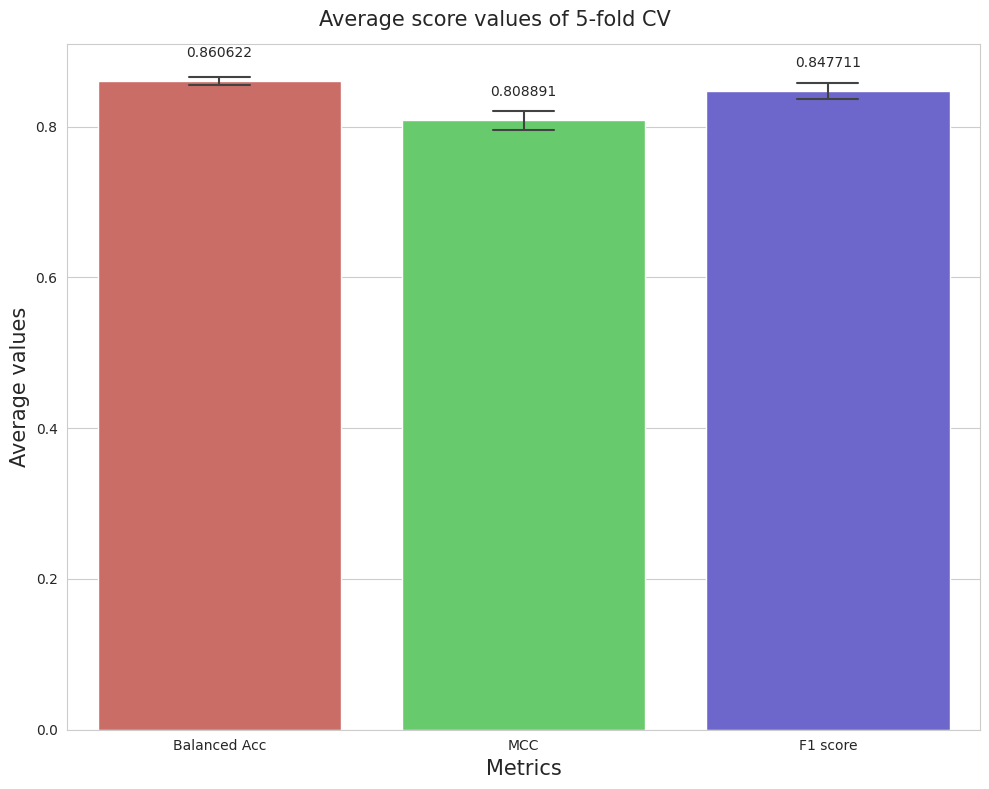

In [23]:
# results_all = [{'train_loss': [0.9627946676576838, 0.5822397846290294, 0.47316639333525123, 0.39256781931309137, 0.33543502599658337, 0.2658478493857033, 0.22722875041996732, 0.15384182246634737, 0.11062711889526862, 0.11631798422005137], 'train_bal_acc': [0.6091899787304201, 0.7695229606994314, 0.8067316727870361, 0.8416224696463664, 0.8756188917531904, 0.9023958027266853, 0.9182873947947481, 0.9444922112201523, 0.9590824453324456, 0.9606721668854021], 'train_mcc': [0.5046721126978047, 0.6956659881691328, 0.7446378628782787, 0.7920744991650878, 0.8293336289326795, 0.8626430571669436, 0.8896701522631675, 0.9277549815086865, 0.9476455117508811, 0.9478035820315381], 'train_f_score': [0.5764503959844526, 0.7475695121590125, 0.7903548963336419, 0.828691154419359, 0.8606508393343952, 0.888321578937471, 0.9095704984092761, 0.9418475459051171, 0.9575628180432906, 0.9579686973158649], 'valid_loss': [0.6238692376543494, 0.5031384326079312, 0.7137555997161305, 0.6586465826805901, 0.47933869765085335, 0.6515201750923606, 0.5889947212794248, 0.597238054170328, 0.7769348428529852, 0.7356662833515335], 'valid_bal_acc': [0.7323448283742404, 0.8003693365458071, 0.7350130588365881, 0.7515209626974333, 0.8162429074193779, 0.7931173891468005, 0.8241127826421945, 0.8116691641691643, 0.7841212708859768, 0.8264171939171938], 'valid_mcc': [0.6542527203496864, 0.7256376960396212, 0.6349606740587214, 0.6848656271500496, 0.7415788773617062, 0.728045761073004, 0.761851475025364, 0.7444149840657195, 0.7031016640431386, 0.7653038862508695], 'valid_f_score': [0.6924230021534177, 0.783871282683441, 0.699959058793528, 0.7387742408302904, 0.7963891694733146, 0.7753176539884288, 0.8108325727017961, 0.8022863996063525, 0.7583216477755697, 0.8134444332136709]}, {'train_loss': [0.22094470042707948, 0.10188348116764032, 0.06340883078176857, 0.08935640290163814, 0.0726748314781991, 0.09337691453915528, 0.038807652789139814, 0.029901945856074558, 0.06315377547349164, 0.05635203638110611], 'train_bal_acc': [0.9298319552179843, 0.969838071266488, 0.9795458626340978, 0.9736874400109696, 0.9706918877690937, 0.9737570232055527, 0.9885131820793587, 0.9913834776334777, 0.9786628934790694, 0.9821724374481725], 'train_mcc': [0.9017634837735359, 0.9583535182914256, 0.9750180133129589, 0.9645811564595826, 0.9620862941927555, 0.9661723744195883, 0.985677443569525, 0.9865841350191097, 0.9719567074864883, 0.9745711663508051], 'train_f_score': [0.9213098211092859, 0.9668753151136336, 0.9801691175977185, 0.9717675983268624, 0.9697754376625564, 0.9728471006168602, 0.988694182403683, 0.9894824845854095, 0.9774755094075767, 0.979915431253171], 'valid_loss': [0.11688099746756694, 0.13029341585934162, 0.11405343343229855, 0.09423722641761689, 0.2148998506805476, 0.12187723641502946, 0.2465956368319252, 0.08732626781634548, 0.1479182612589177, 0.13273587559952454], 'valid_bal_acc': [0.9727839317545199, 0.962784437784438, 0.9659344903462551, 0.9675381318028377, 0.9235903149138442, 0.9643027723910078, 0.9286674926380811, 0.9666677276971396, 0.9470152559858441, 0.9509650480238714], 'valid_mcc': [0.9629681326678633, 0.9448460259261514, 0.9442269517652465, 0.9518112938000175, 0.8965415504251522, 0.9423298323015158, 0.8996505940744579, 0.9529406198563762, 0.924817099778222, 0.9320419251532318], 'valid_f_score': [0.9705558434798365, 0.955983688323209, 0.9550065949809566, 0.9618940477458962, 0.9142959554987553, 0.9544881483345679, 0.917136192528707, 0.9623426361154149, 0.9411880873886017, 0.9460917660315218]}, {'train_loss': [0.06762893128753229, 0.05494115112849292, 0.02613393446389476, 0.10907816171461224, 0.027126011442519752, 0.043210910971966394], 'train_bal_acc': [0.9789494839311016, 0.9817977406580349, 0.9928306538233007, 0.9735875603155015, 0.9920097875980228, 0.9873876776817951], 'train_mcc': [0.9722958314298159, 0.9780428647127299, 0.9901875779121483, 0.9639712121590098, 0.9891511712688287, 0.981923693640073], 'train_f_score': [0.9782620150489221, 0.9820108094492473, 0.9922769287690967, 0.9716387626380323, 0.9915904550206172, 0.9856016278012594], 'valid_loss': [0.020652413871550167, 0.021704104907043716, 0.0655968176707735, 0.0749868821927949, 0.030752411125885212, 0.04114580967956606], 'valid_bal_acc': [0.9935480859010272, 0.9965569561157795, 0.9811367880485529, 0.9803335879806471, 0.9898832866479924, 0.9850000000000001], 'valid_mcc': [0.9906118212571187, 0.9941054386764212, 0.972342217450547, 0.9732176264882949, 0.9880664391994429, 0.9802213955805629], 'valid_f_score': [0.9926090193459278, 0.9954433336717985, 0.9782121886896251, 0.9787484681681539, 0.9906909107003827, 0.9841428250569593]}, {'train_loss': [0.13723791189766096, 0.03477925102411331, 0.046606388449457456, 0.03756942905281047, 0.0335527715527432, 0.029309230205185218, 0.035920373059906634], 'train_bal_acc': [0.95923286272551, 0.9891662749015692, 0.9876907936834404, 0.9888941777177072, 0.9896807359307358, 0.9893433812919108, 0.9895025358628295], 'train_mcc': [0.950269607163429, 0.9852372440662457, 0.9834717907452831, 0.9855626472448141, 0.9873339127671282, 0.986428306927844, 0.9851316147449033], 'train_f_score': [0.959927854547292, 0.9882443428441481, 0.9868846505498463, 0.9884224203671972, 0.9898371301826077, 0.9891666582174231, 0.9881729379713178], 'valid_loss': [0.07403050231582978, 0.013959448302664575, 0.05595329633968718, 0.03395577842499787, 0.07638179524185355, 0.04103120454986792, 0.07244019100428833], 'valid_bal_acc': [0.9814141414141413, 0.9932539682539682, 0.9808492487904253, 0.9883356676003734, 0.9764043146396089, 0.9902334267040148, 0.9792549444020032], 'valid_mcc': [0.9767408026920523, 0.992963806982357, 0.9757883123500872, 0.9861004324562993, 0.9597633221291392, 0.9873712122100303, 0.9692021411244428], 'valid_f_score': [0.9815061486922261, 0.9942960918725239, 0.9805266200973134, 0.9889372644376275, 0.968391074026222, 0.9898412176551972, 0.9751242006462624]}, {'train_loss': [0.03633734955099713, 0.04700147283785876, 0.042516198410981705, 0.04194321836225486, 0.021643497164297837, 0.0040473770212456125, 0.051363232196208364, 0.07290867624739322, 0.06098386895802618, 0.026948013557664713], 'train_bal_acc': [0.9890944145723557, 0.9842481374834317, 0.9894665873342343, 0.9844164944532592, 0.9934261071852982, 0.9990079365079365, 0.9872722498090146, 0.9778680388239214, 0.9833868827251178, 0.9915120418796891], 'train_mcc': [0.9844102122022608, 0.9801894534300869, 0.9846994908745242, 0.977607296759242, 0.9910342756678618, 0.9985404356434461, 0.9825923782314168, 0.9701661092138624, 0.97759185830708, 0.9881811602389928], 'train_f_score': [0.9876980502944451, 0.9843925563148287, 0.9878980055494777, 0.98227107473525, 0.9929781902935175, 0.9988662950042937, 0.9861424566542984, 0.9760796425249614, 0.9823061662905994, 0.990579480171223], 'valid_loss': [0.014132972396242515, 0.03458607899494168, 0.09961753474164974, 0.011430984362959862, 0.031713323790908736, 0.004898638243342729, 0.11650880761718486, 0.044840588953400796, 0.07334855611449764, 0.036708449968821645], 'valid_bal_acc': [0.9973529411764707, 0.9932698837110602, 0.9692201426024956, 0.9969815805109924, 0.9884708428826076, 0.998235294117647, 0.964940794499618, 0.9873919870978694, 0.9792693744164334, 0.9896914523385112], 'valid_mcc': [0.9964520962755844, 0.9895101948698816, 0.9662944753411852, 0.995417112367331, 0.9861904776820731, 0.9977223668307351, 0.9557715511308457, 0.9836628181802924, 0.9729234792318794, 0.9844905563411527], 'valid_f_score': [0.9972176977611762, 0.991839540486734, 0.97322148219663, 0.996340600719926, 0.9889312676942436, 0.9981700714576102, 0.9647638778947112, 0.9870576999279791, 0.978813605073408, 0.9879748123368364]}]
# plot cross validation's average scores on the validation splits
import pandas as pd
# mean_bal_acc = np.mean([max(results_all[i]['valid_bal_acc']) for i in range(len(results_all))])
# mean_mcc = np.mean([max(results_all[i]['valid_mcc']) for i in range(len(results_all))])
# mean_f_score = np.mean([max(results_all[i]['valid_f_score']) for i in range(len(results_all))])
# mean_scores = [mean_bal_acc, mean_mcc, mean_f_score]
# score_names = ['Balanced Acc', 'MCC', 'F1 score']
my_dict = {'Balanced Acc': [max(results_all[i]['valid_bal_acc']) for i in range(len(results_all))], 
           'MCC': [max(results_all[i]['valid_mcc']) for i in range(len(results_all))], 
           'F1 score': [max(results_all[i]['valid_f_score']) for i in range(len(results_all))]}

my_df = pd.DataFrame(my_dict)
print(my_df)
plt.rcParams["figure.autolayout"] = True
plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
ax = sns.barplot(data= my_df, estimator=np.mean, color='blue', palette='hls', errorbar="sd", capsize=.2, errwidth=1.5)
ax.bar_label(ax.containers[0], padding=15)

plt.xlabel('Metrics', fontsize=15)
plt.ylabel(f'Average values', fontsize=15)

plt.suptitle(f'Average score values of 5-fold CV', fontsize=15)
plt.savefig(f'/kaggle/working/vgg16_cv_scores.png')
plt.show()

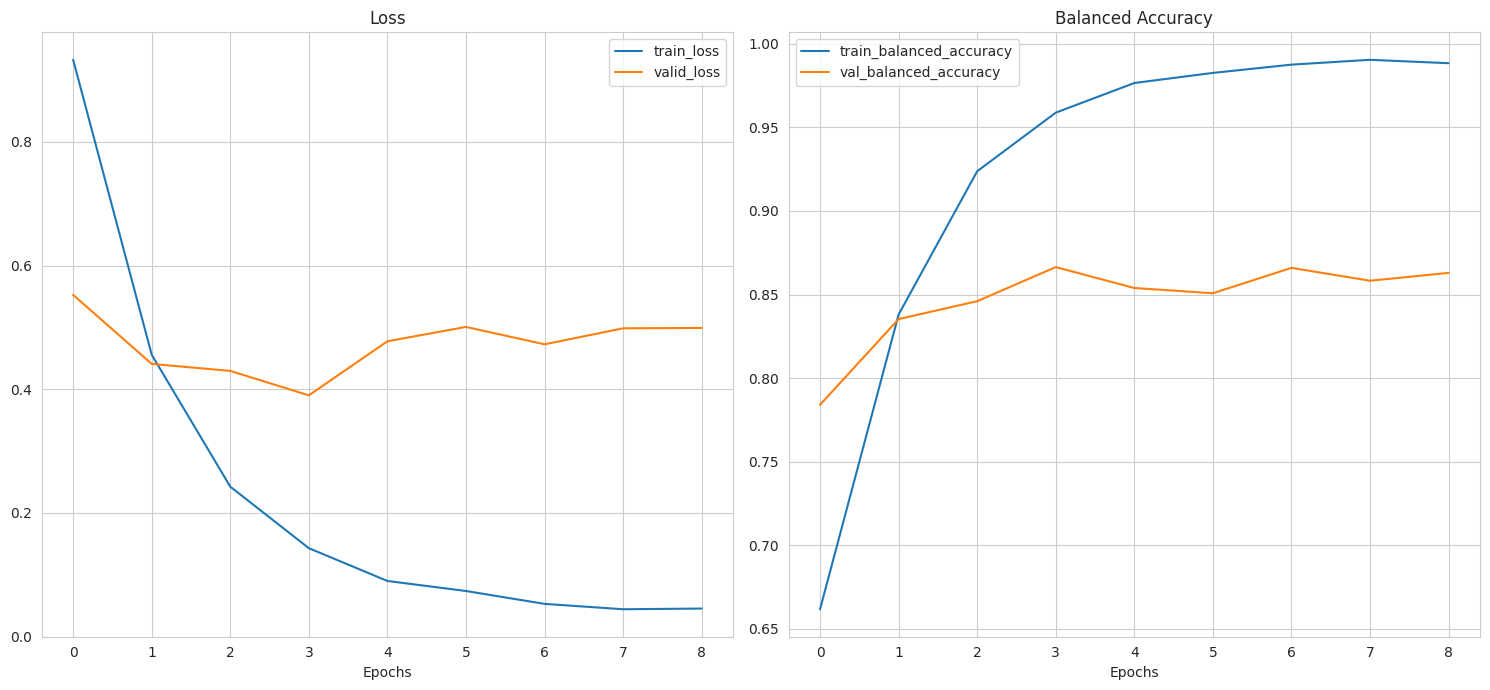

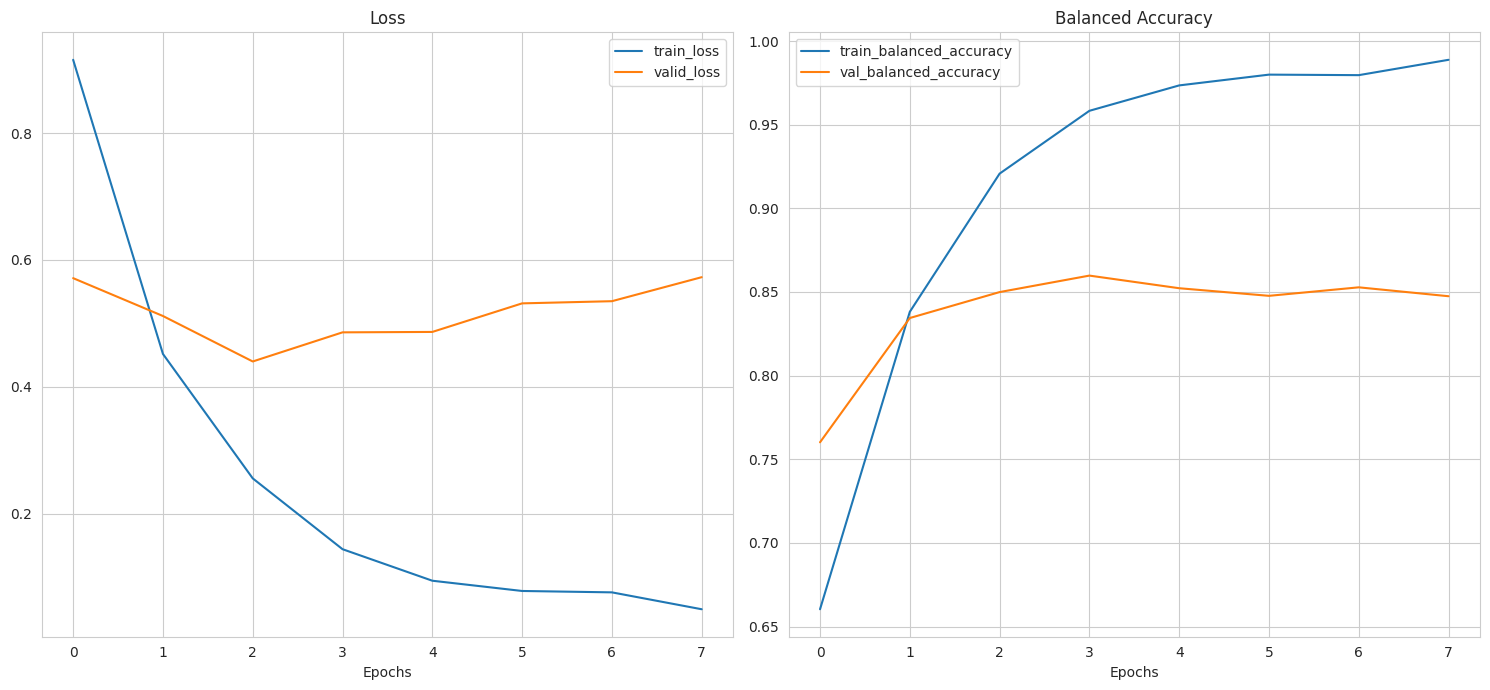

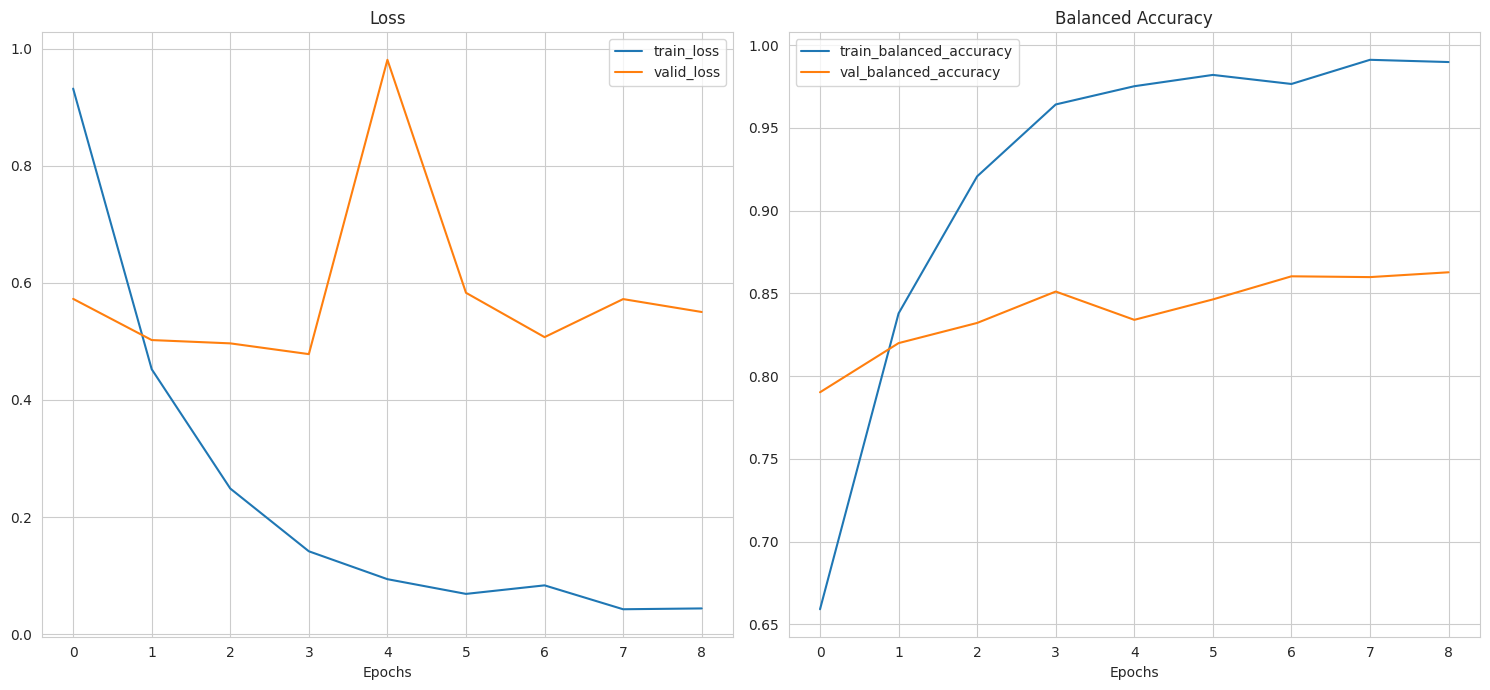

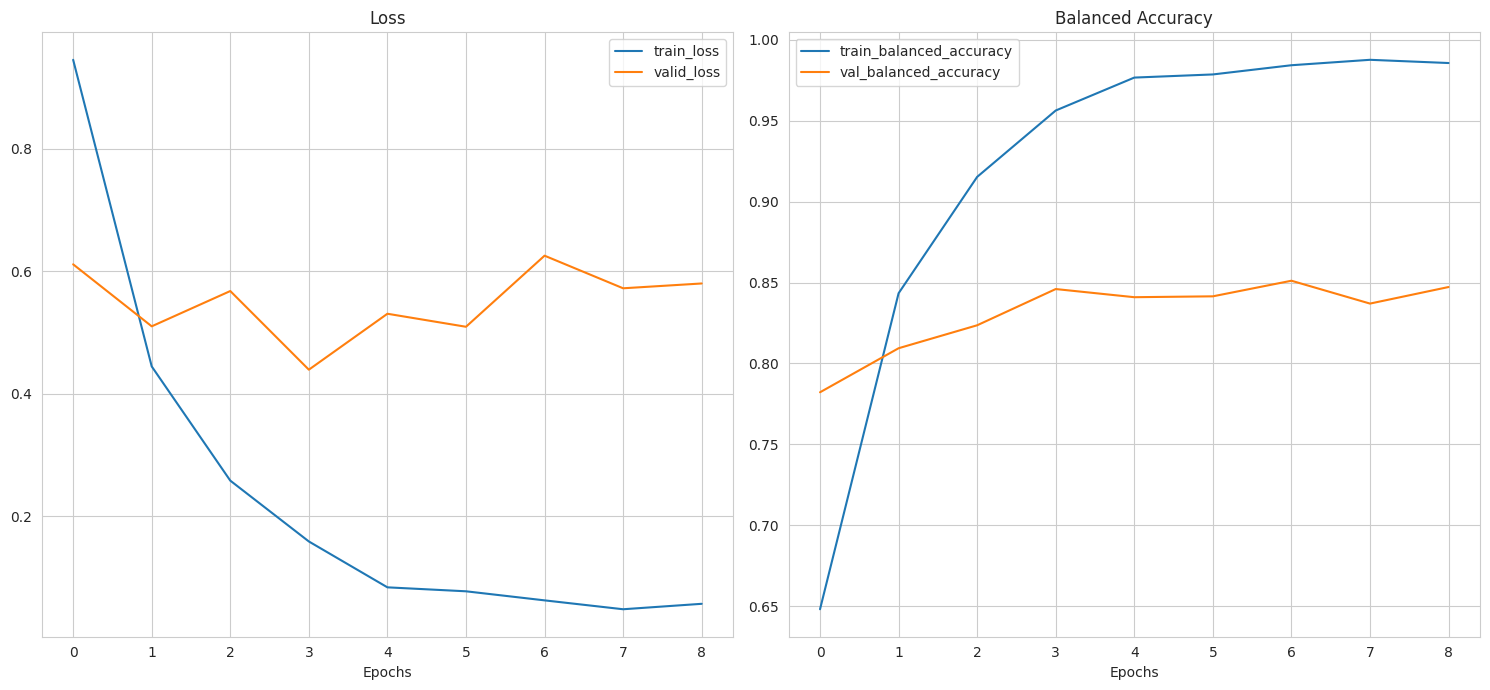

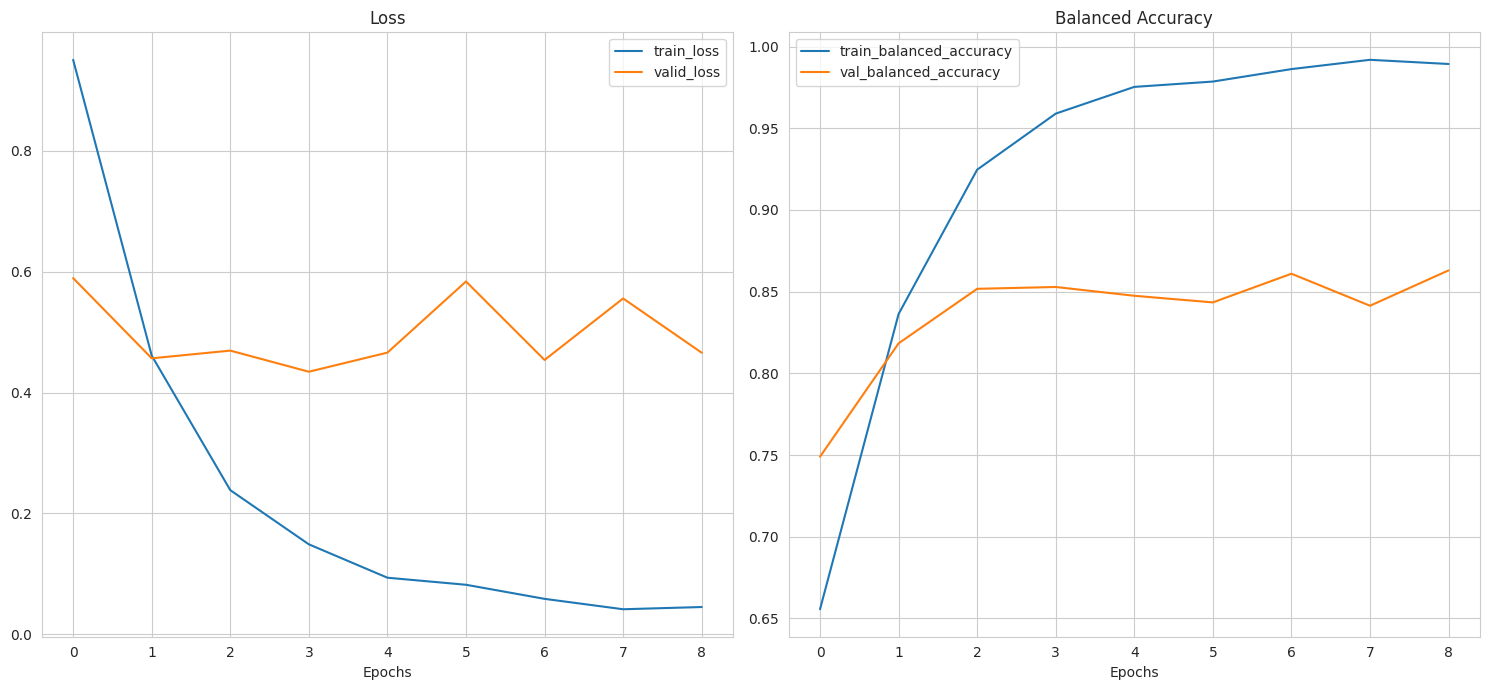

In [24]:
# Plot the loss curves of our model
for i in range(len(results_all)):
    helper_functions.plot_loss_curves(results_all[i])
    plt.savefig(f'/kaggle/working/resnet50_loss_curves_split_{i}.png')

# Final model

Train a final model and evaluate it on the held out test set

Start Training of final model


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9085 | train_bal_acc: 0.6713 | train_mcc: 0.5691 | valid_loss: 0.5988 | valid_bal_acc: 0.7508 | valid_mcc: 0.6913
Epoch: 2 | train_loss: 0.4386 | train_bal_acc: 0.8408 | train_mcc: 0.7773 | valid_loss: 0.5007 | valid_bal_acc: 0.8064 | valid_mcc: 0.7557
Epoch: 3 | train_loss: 0.2354 | train_bal_acc: 0.9256 | train_mcc: 0.8880 | valid_loss: 0.4358 | valid_bal_acc: 0.8374 | valid_mcc: 0.7864
Epoch: 4 | train_loss: 0.1238 | train_bal_acc: 0.9665 | train_mcc: 0.9484 | valid_loss: 0.5337 | valid_bal_acc: 0.8230 | valid_mcc: 0.7657
Epoch: 5 | train_loss: 0.0873 | train_bal_acc: 0.9759 | train_mcc: 0.9627 | valid_loss: 0.5704 | valid_bal_acc: 0.8010 | valid_mcc: 0.7538
Epoch: 6 | train_loss: 0.0815 | train_bal_acc: 0.9790 | train_mcc: 0.9654 | valid_loss: 0.6730 | valid_bal_acc: 0.8125 | valid_mcc: 0.7598
Epoch: 7 | train_loss: 0.0565 | train_bal_acc: 0.9850 | train_mcc: 0.9741 | valid_loss: 0.5434 | valid_bal_acc: 0.8434 | valid_mcc: 0.7934
Epoch: 8 | train_loss: 0.06

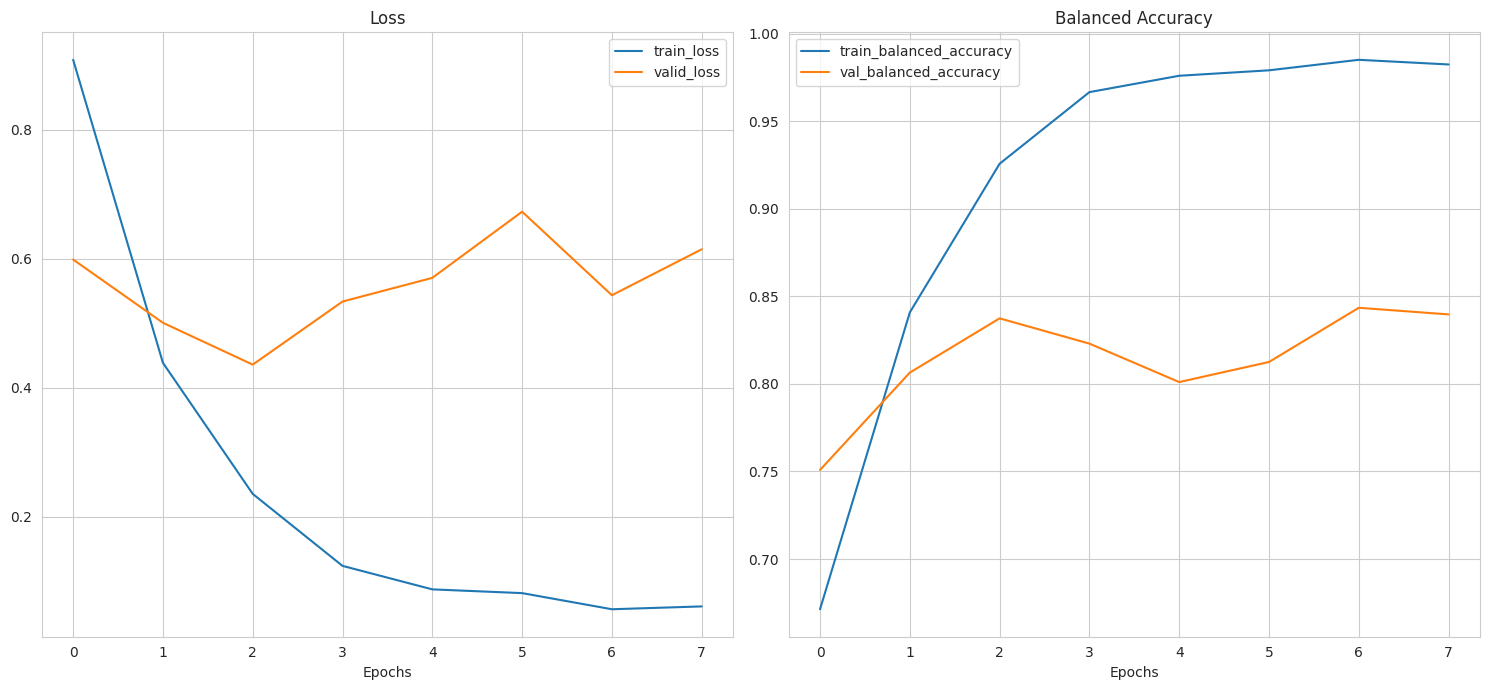

In [25]:
# train final model on the reduced set with a split 85-15 train-val
reduced_dataset = train_subset
train_indices, val_indices = train_test_split(train_idx, test_size=0.15, stratify=train_targets, random_state=42)  # set seed to ensure reproducibility
                                              
train_subset = Subset(train_dataset, train_indices)
train_targets=[train_dataset.targets[i] for i in train_indices]
                                              
val_subset = Subset(train_dataset, val_indices)
val_targets=[train_dataset.targets[i] for i in val_indices]
                                              
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
                                              
                                              
start_time = timer()

# Load the model
weights = models.ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=weights).to(device)
num_ftrs = resnet.fc.in_features

resnet.fc = nn.Linear(num_ftrs, 5).to(device)

# Set the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.01)

print('Start Training of final model')
results, final_model = engine.train_with_early_stopping(model=resnet,
                                              train_dataloader=train_loader,
                                              valid_dataloader=val_loader,
                                              optimizer=optimizer,
                                              loss_fn=loss_fn,
                                              epochs=10,
                                              device=device)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds\n")

MODEL_SAVE_PATH = os.path.join('/kaggle/working/', '01_resnet50_final_model.pth')
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=final_model.state_dict(), f=MODEL_SAVE_PATH)
                                              
helper_functions.plot_loss_curves(results)
plt.savefig(f'/kaggle/working/training_curves_resnet50_final_model.png')

In [26]:
len(train_targets)

4913

## Test final model on the held out test set

In [30]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, f1_score
# loaded_model_vgg16 = models.vgg16()
# loaded_model_vgg16.load_state_dict(torch.load(f=MODEL_SAVE_PATH), strict=False)
# loaded_model_vgg16 = loaded_model_vgg16.to(device)
loaded_model_vgg16 = final_model

loaded_model_vgg16.eval()
with torch.inference_mode():
    all_predictions = []
    all_true_labels = []
    
    test_loss, test_bal_acc, test_mcc, test_f_score = 0, 0, 0, 0
    for batch, (X, y) in enumerate(test_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred_logits = loaded_model_vgg16(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(test_pred_logits, y)
        test_loss += loss.item()

        # Calculate and accumulate scores
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_bal_acc += balanced_accuracy_score(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_mcc += matthews_corrcoef(y.cpu().numpy(), test_pred_labels.cpu().numpy())
        test_f_score += f1_score(y.cpu().numpy(), test_pred_labels.cpu().numpy(), average='weighted')
        
        all_predictions.extend(test_pred_labels.cpu().numpy())
        all_true_labels.extend(y.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(test_loader)
    test_bal_acc = test_bal_acc / len(test_loader)
    test_mcc = test_mcc / len(test_loader)
    test_f_score = test_f_score / len(test_loader)
    print(f'Test loss: {test_loss} | Test bal acc {test_bal_acc} | Test mcc {test_mcc} | Test_f_score {test_f_score}\n')   
    



Test loss: 0.4245750610716641 | Test bal acc 0.8751918047230547 | Test mcc 0.8283831289333162 | Test_f_score 0.8619944594790513



## Confusion matrix on the test set

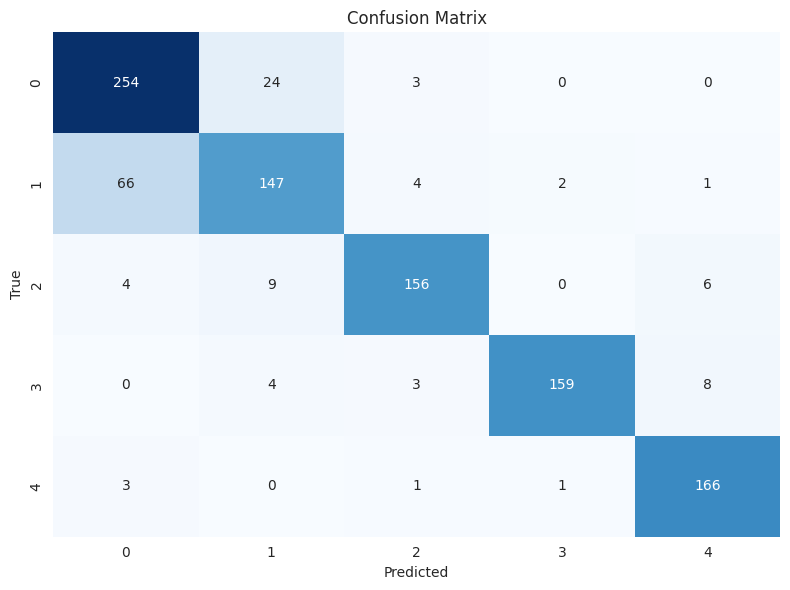

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f'/kaggle/working/vgg16_final_model_cm.png', dpi=300)
plt.show()


In [32]:
# Generate the classification report
report = classification_report(all_true_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       281
           1       0.80      0.67      0.73       220
           2       0.93      0.89      0.91       175
           3       0.98      0.91      0.95       174
           4       0.92      0.97      0.94       171

    accuracy                           0.86      1021
   macro avg       0.88      0.87      0.87      1021
weighted avg       0.87      0.86      0.86      1021



# Grad Cam

In [34]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=8245a7abfd1b102bb77d63ea50f797837265da7a0d115c4e9305a91a076385db
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [40]:
from PIL import Image

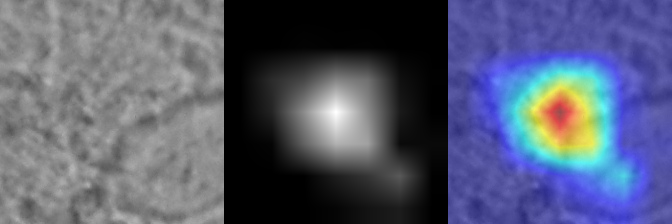

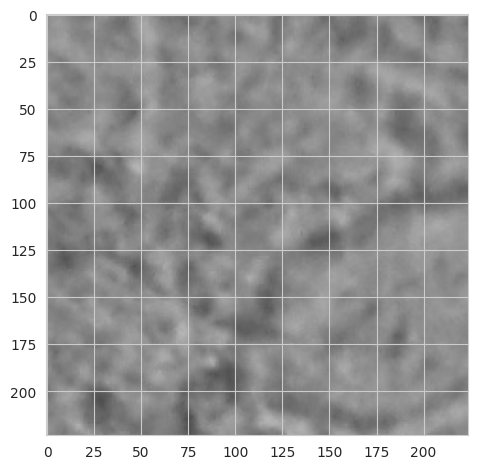

In [41]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
for param in resnet.parameters():
    param.requires_grad = True

resnet.eval()

# img, = testset[123]
# input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
from torchvision.transforms.functional import to_tensor
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image




# img = np.array(Image.open('/kaggle/input/sample/sample/sample/images/00000013_005.png'))
import cv2 
 
# Load the grayscale image 
image = cv2.imread('/kaggle/input/fungi-all/H1/H1_100a_1.jpg.jpg', cv2.IMREAD_GRAYSCALE) 
#print(data.head())
#print(data[data["Image Index"]=='00024733_000.png'])
# Convert the image to RGB 
# Load the grayscale image 
 
# Convert the image to RGB 
img = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
import matplotlib.pyplot as plt
plt.imshow(img)

img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
target_layers = [resnet.layer4]
cam= GradCAM(model=resnet, target_layers=target_layers,use_cuda=True) 
grayscale_cams = cam(input_tensor=input_tensor.to(device))
cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)